# Import

In [1]:
import torch
import numpy as np
from tqdm import tqdm
from torch_geometric.loader import DataLoader
import pdb, os
import yaml
import math
import joblib
from utils.dataset import CovarianceTemporalDataset, CovarianceLSTMDataset
from utils.tools import back_to_matcov
from utils.models import GATModel, RecurrentGCN
from utils.dataset import CovarianceTemporalDataset,CovarianceLaggedDataset,CovarianceSparseDataset,CovarianceLaggedMultiOutputDataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from glob import glob
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
from linearmodels import PanelOLS
import statsmodels.api as sm

In [2]:
os.environ["PATH"] += os.pathsep + 'YOURPATH'

# 'YOURPATH' could like like 'C:\\Users\\USERNAME\\AppData\\Local\\Programs\\MiKTeX\\miktex\\bin\\x64' on Windows

columnwidth = 418.25 
style = "white"  # darkgrid
fsize = 14
params = {
    "text.usetex": True,
    "savefig.dpi": 300,
    "font.family": "serif",  #       : serif
    "font.serif": "Computer Modern Roman",  # : Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
    "font.size": fsize,
    "legend.fontsize": fsize,
    "xtick.labelsize": fsize,
    "ytick.labelsize": fsize,
    "axes.titlesize": fsize,
}
plt.rcParams.update(params)

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    # fig_height_in = fig_width_in * golden_ratio
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

def create_figure(width=800):

    return plt.subplots(figsize=set_size(width=width))


def create_figures(nrows, ncols, width=800, tupsize=None):
    if width:
        return plt.subplots(nrows=nrows, ncols=ncols, figsize=set_size(width=width))
    else:
        return plt.subplots(nrows=nrows, ncols=ncols, figsize=tupsize)
    

def qlike(y,yhat):
    return y/yhat - np.log(y/yhat) - 1

import torch.nn as nn
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
class GATModel(torch.nn.Module):
    def __init__(self, 
                 num_node_features,
                 num_edge_features,
                 num_heads, 
                 output_node_channels, 
                 dim_hidden_layers=[100], 
                 dropout_att=0.0, 
                 dropout=0.0,
                 activation='relu',
                 concat_heads=False,
                 negative_slope=0.2,
                 standardize = False):
        super(GATModel, self).__init__()
        self.dropout = dropout
        self.activation = activation
        self.standardize = standardize
        

        if self.standardize:
            self.bnorm_node = nn.BatchNorm1d(num_node_features, affine=False)
            self.bnorm_edge = nn.BatchNorm1d(num_edge_features, affine=False)
        
        
        if len(dim_hidden_layers) == 1:
            first_gat = [GATConv(in_channels=num_node_features, out_channels=dim_hidden_layers[0], heads=num_heads,  
                                        concat=False, dropout=dropout_att, edge_dim=num_edge_features, negative_slope=negative_slope)]
        else:
            first_gat = [GATConv(in_channels=num_node_features, out_channels=dim_hidden_layers[0], heads=num_heads,  
                                        concat=concat_heads, dropout=dropout_att, edge_dim=num_edge_features, negative_slope=negative_slope)]
                     
        stacked_gats = []
        
        for i in range(len(dim_hidden_layers)-1):
            if i+1 == len(dim_hidden_layers)-1:
                if concat_heads and num_heads>1:
                    stacked_gats.append(GATConv(in_channels=dim_hidden_layers[i] * num_heads, 
                                                out_channels=dim_hidden_layers[i+1], heads=num_heads, 
                                                concat=False, dropout=dropout_att, edge_dim=num_edge_features, negative_slope=negative_slope))
                else:
                    stacked_gats.append(GATConv(in_channels=dim_hidden_layers[i], 
                                                out_channels=dim_hidden_layers[i+1], heads=num_heads, 
                                                concat=False, dropout=dropout_att, edge_dim=num_edge_features, negative_slope=negative_slope))
            else:
                if concat_heads and num_heads>1:
                    stacked_gats.append(GATConv(in_channels=dim_hidden_layers[i] * num_heads, 
                                                out_channels=dim_hidden_layers[i+1], heads=num_heads, 
                                                concat=concat_heads, dropout=dropout_att, edge_dim=num_edge_features, negative_slope=negative_slope))
                else:
                    stacked_gats.append(GATConv(in_channels=dim_hidden_layers[i], 
                                                out_channels=dim_hidden_layers[i+1], heads=num_heads, 
                                                concat=concat_heads, dropout=dropout_att, edge_dim=num_edge_features, negative_slope=negative_slope))

        

        self.gat_layers = nn.ModuleList(first_gat + stacked_gats)


        self.linear = torch.nn.Linear(dim_hidden_layers[-1], output_node_channels)
        # Apply Xavier initialization to the linear layers
        # torch.nn.init.xavier_uniform_(self.linear.weight)

        
        if self.activation == 'relu':
            self.a = F.relu
        elif self.activation == 'tanh':
            self.a = F.tanh
        elif self.activation == 'sigmoid':
            self.a = F.sigmoid        
        else:
            print('Choose an available activation function')
            sys.exit()



    def forward(self, data):
        x, edge_index, edge_attr = (data.x,
                                    data.edge_index,
                                    data.edge_attr)
        self.attention_weights = []  # Initialize list to store attention weights
        if self.standardize:
            x = self.bnorm_node(x)
            edge_attr = self.bnorm_node(edge_attr)
        for l in self.gat_layers:
            x, alpha = l(x, edge_index, edge_attr, return_attention_weights=True)
            self.attention_weights.append(alpha)
            x = self.a(x)
            if self.dropout:
                x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.linear(x)

        return x.view(-1) 


# Load dataset and model

In [3]:
# Load general hyperparam file
with open('config/GNN_param.yaml', 'r') as f:
    p = yaml.safe_load(f)
plot_losses = p['plot_losses']
naive_benchmark = p['naive_benchmark']
# Define the folder path
folder_path = 'output/{}'.format(p['model_to_load'])

if 'optuna' in folder_path:
    df = pd.read_csv('{}/study.csv'.format(folder_path), index_col=0)
    df.set_index('number',inplace=True)
    idx = df.sort_values('value').index[0]
    folder_path = os.path.join(folder_path,str(idx))

# folder_path = os.path.join(folder_path,str(38))

# Load trained model hyperparam file
with open('{}/GNN_param.yaml'.format(folder_path), 'r') as f:
    p = yaml.safe_load(f)
p['plot_losses'] = plot_losses
p['naive_benchmark'] = naive_benchmark
# fix randomness
torch.manual_seed(p['seed'])
np.random.seed(p['seed'])
torch.cuda.manual_seed_all(p['seed'])


# Instantiate the dataset
if p['fully_connected']:
    if p['output_node_channels'] == 1:
        dataset = CovarianceLaggedDataset(hdf5_file1=p['volfile'], hdf5_file2=p['volvolfile'],root='_'.join([p['root'],str(p['seq_length'])]), seq_length=p['seq_length'])
    else:
        dataset = CovarianceLaggedMultiOutputDataset(hdf5_file1=p['volfile'], hdf5_file2=p['volvolfile'],root='_'.join([p['root'],str(p['seq_length']),'moutput']), seq_length=p['seq_length'], future_steps=p['output_node_channels'])
else:
    if p['threshold']:
        root = '_'.join([p['root'],'sparse','t_{}'.format(p['threshold']),str(p['seq_length'])])
    else:
        root = '_'.join([p['root'],'sparse',str(p['seq_length'])])
    dataset = CovarianceSparseDataset(hdf5_file=p['datafile'],root=root, seq_length=p['seq_length'], threshold=p['threshold'])
    p['num_edge_features'] = 1
# train-test split data
train_size = int(p['split_proportion'] * len(dataset))
train_dataset, test_dataset = dataset[:train_size], dataset[train_size:]
    
len_dataset = len(dataset)

# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=p['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=p['batch_size'], shuffle=False)

# select dimensions from data
NODE_FEATURES = dataset[0].x.shape[1]
EDGE_FEATURES = dataset[0].edge_attr.shape[1]

# Instantiate the model
if p['modeltype'] == 'gat':
    model = GATModel(num_node_features=NODE_FEATURES, 
                     num_edge_features = EDGE_FEATURES,
                     num_heads=p['num_heads'], 
                     output_node_channels=p['output_node_channels'], 
                     dim_hidden_layers=p['dim_hidden_layers'],
                     dropout_att = p['dropout_att'],
                     dropout = p['dropout'],
                     activation = p['activation'],
                     concat_heads= p['concat_heads'],
                     negative_slope=p['negative_slope'],
                     standardize = p['standardize'])
elif p['modeltype'] == 'rnn':
    model = RecurrentGCN(num_features=p['seq_length'], 
                     hidden_channels=p['hidden_channels'], 
                     output_node_channels=p['output_node_channels'], 
                     dropout = p['dropout'],
                     activation = p['activation'])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load saved model weights
modelweights = os.path.join(folder_path,'{}_weights_seed_{}.pth'.format(p['modelname'], p['seed']))
model.load_state_dict(torch.load(modelweights, map_location=device))

scalers = pd.read_csv('processed_data/vols_mean_std_scalers.csv',index_col=0)

In [4]:
df.loc[idx]

value                                         0.316838
datetime_start              2024-04-27 23:08:53.058952
datetime_complete           2024-04-27 23:14:30.219851
duration                        0 days 00:05:37.160899
params_dim_hidden_layers                    [300, 150]
params_dropout                                     0.2
params_dropout_att                                 0.0
params_learning_rate                           0.00005
params_negative_slope                             0.05
params_num_heads                                     7
params_optimizer                                 adamw
state                                         COMPLETE
Name: 181, dtype: object

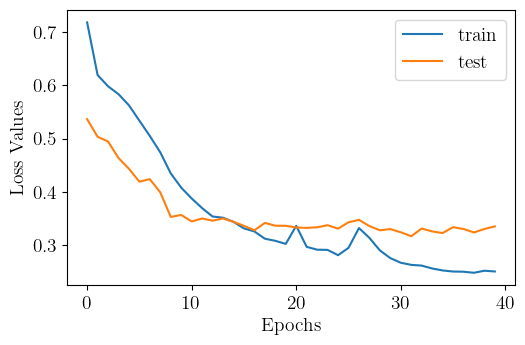

In [5]:
if p['plot_losses']:
    train_loss = np.load('{}/train_losses_seed_{}.npy'.format(folder_path, p['seed']))
    test_loss = np.load('{}/test_losses_seed_{}.npy'.format(folder_path, p['seed']))
    fig2,ax2 = plt.subplots(figsize=set_size(columnwidth))
    # ax2.plot(np.arange(len(train_loss)),np.log(train_loss), label='train')
    # ax2.plot(np.arange(len(train_loss)),np.log(test_loss), label='test')
    ax2.plot(np.arange(len(train_loss)),train_loss, label='train')
    ax2.plot(np.arange(len(train_loss)),test_loss, label='test')
    ax2.legend()
    ax2.set_ylabel('Loss Values')
    ax2.set_xlabel('Epochs')

In [6]:
p['output_node_channels']

1

# Model eval

In [7]:
# Evaluate on the train set
model.eval()
criterion = torch.nn.MSELoss()

train_loss = 0
preds_train = []
actual_train = []
naive_benchmark = []
with torch.no_grad():
    for data in tqdm(iterable=train_loader, desc='Testing batches...'):
        data = data.to(device)
        # Forward pass
        y_x_hat = model(data) *scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        preds_train.append(y_x_hat)
        # Compute loss
        y_x = data.y_x *scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        actual_train.append(y_x)

        naive_benchmark.append(data.x[:,0])

        train_loss += criterion(y_x_hat,y_x)
        
# Compute average test loss
mse = train_loss / len(train_loader)
rmse = math.sqrt(mse)

print('MSE',mse)
# print('RMSE',rmse)

preds_train = torch.concat(preds_train)
actual_train = torch.concat(actual_train)
# torch.save(preds_train, 'predictions/single_GAT_train.pt')
# torch.save(actual_train, 'predictions/single_actual_train.pt')
# torch.save(preds_train, 'predictions/single_GATnoedge_train.pt')

reshaped_preds_train = preds_train.view(-1,30)
reshaped_actual_train = actual_train.view(-1,30)

Testing batches...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [03:58<00:00,  1.01s/it]

MSE tensor(4.2210e-08)
Average vol of the period 0.00023774538
RMSE 0.0002053791604201897
RRMSE 0.6194635
NRMSE 0.8836142190281672
RSE 0.3992537


In [7]:
# Evaluate on the test set
model.eval()
criterion = torch.nn.MSELoss()

test_loss = 0
preds_val = []
actual_val = []
naive_benchmark = []
with torch.no_grad():
    for data in tqdm(iterable=test_loader, desc='Testing batches...'):
        data = data.to(device)
        # if p['scale_up']:
        #     data.x = data.x * p['scale_up'] 
        #     data.edge_attr = data.edge_attr * p['scale_up'] 
        #     data.y_x = data.y_x * p['scale_up']
        # Forward pass
        y_x_hat = model(data)*scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        preds_val.append(y_x_hat)
        # Compute loss
        y_x = data.y_x*scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        actual_val.append(y_x)


        test_loss += criterion(y_x_hat,y_x)
        
# Compute average test loss
mse = test_loss / len(test_loader)
rmse = math.sqrt(mse)


preds_val = torch.concat(preds_val)
actual_val = torch.concat(actual_val)
# torch.save(preds_val, 'predictions/single_GAT_val.pt')
# torch.save(actual_val, 'predictions/single_actual_val.pt')
# torch.save(preds_val, 'predictions/single_GATnoedge_val.pt')

reshaped_preds_val = preds_val.view(-1,30)
reshaped_actual_val = actual_val.view(-1,30)

qlike_val = qlike(actual_val.numpy(), preds_val.numpy())

# Create DataFrame
gnn_val_metrics = pd.DataFrame({
    'Value': [mse.numpy(), qlike_val]
}, index = ['MSE', 'QLIKE'])

gnn_val_metrics

Testing batches...: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.83s/it]


,Value
MSE,3.500568e-08
RMSE,0.000173
R2,0.620884
QLIKE,1.000292


## Repeat on test set, after validation set

In [8]:
p['volvolfile'] = 'processed_data/volvols_mats_taq_standardized.h5'
p['volfile'] = 'processed_data/vols_mats_taq_standardized.h5'
p['root'] =  'processed_data/vols_mats_taq_standardized_test'

# Instantiate the dataset
if p['fully_connected']:
    if p['output_node_channels'] == 1:
        test_dataset = CovarianceLaggedDataset(hdf5_file1=p['volfile'], hdf5_file2=p['volvolfile'],root='_'.join([p['root'],str(p['seq_length'])]), seq_length=p['seq_length'])
    else:
        test_dataset = CovarianceLaggedMultiOutputDataset(hdf5_file1=p['volfile'], hdf5_file2=p['volvolfile'],root='_'.join([p['root'],str(p['seq_length']),'moutput']), seq_length=p['seq_length'], future_steps=p['output_node_channels'])
else:
    if p['threshold']:
        root = '_'.join([p['root'],'sparse','t_{}'.format(p['threshold']),str(p['seq_length'])])
    else:
        root = '_'.join([p['root'],'sparse',str(p['seq_length'])])
    test_dataset = CovarianceSparseDataset(hdf5_file=p['datafile'],root=root, seq_length=p['seq_length'], threshold=p['threshold'])
    p['num_edge_features'] = 1

len_test_dataset = len(test_dataset)
    
test_loader = DataLoader(test_dataset, batch_size=p['batch_size'], shuffle=False)

# Evaluate on the test set
model.eval()
criterion = torch.nn.MSELoss()

test_loss = 0
preds_test = []
actual_test = []
with torch.no_grad():
    for data in tqdm(iterable=test_loader, desc='Testing batches...'):
        data = data.to(device)
        # Forward pass
        y_x_hat = model(data)*scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        preds_test.append(y_x_hat)
        # Compute loss
        y_x = data.y_x *scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        actual_test.append(y_x)


        test_loss += criterion(y_x_hat,y_x)
        
# Compute average test loss
mse = test_loss / len(test_loader)
rmse = math.sqrt(mse)


preds_test = torch.concat(preds_test)
actual_test = torch.concat(actual_test)
# torch.save(preds_test, 'predictions/single_GAT_test.pt')
# torch.save(actual_test, 'predictions/single_actual_test.pt')
# torch.save(preds_test, 'predictions/single_GATnoedge_test.pt')

reshaped_preds_test = preds_test.view(-1,30)
reshaped_actual_test = actual_test.view(-1,30)

qlike_val = qlike(actual_test.numpy(), preds_test.numpy())

# Create DataFrame
gnn_test_metrics = pd.DataFrame({

    'Value': [mse.numpy(), qlike_val]
}, index = ['MSE', 'QLIKE'])

gnn_test_metrics

Testing batches...: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:38<00:00,  2.28s/it]


,Value
MSE,3.550524e-08
RMSE,0.000188
R2,0.499404
QLIKE,1.003778


# HAR benchmark

In [7]:
df_to_concat = []
for filename in tqdm(glob(os.path.join(os.getcwd(),'processed_data','vol','*.csv')),desc='Joining RVols...'):
    df = pd.read_csv(filename, header=None)
    # df = df.stack().reset_index(drop=True)
    df = pd.concat([df[col] for col in df], ignore_index=True)
    symbol = filename.split('\\')[-1].split('.')[0]
    df.name = symbol
    df_to_concat.append(df)


vol_df = pd.concat(df_to_concat,axis=1).loc[p['seq_length'] - 14:].reset_index(drop=True)
sorted_columns = sorted(vol_df.columns)
vol_df = vol_df[sorted_columns]

companies = list(vol_df.columns)

toconcat = []
# Loop through each column (company)
for col in vol_df.columns:
    temp_df = vol_df[[col]].copy()
    temp_df['company'] = col
    
    # Create lagged features
    temp_df.rename(columns={col:'RV'}, inplace=True)
    temp_df['RV_lag_day'] = temp_df['RV'].shift(1)
    temp_df['RV_lag_week'] = temp_df['RV'].shift(1).rolling(window = 7).mean()
    temp_df['RV_lag_month'] = (temp_df['RV'].shift(1).rolling(window = 14).sum()-temp_df['RV'].shift(1).rolling(window = 7).sum())/ 7
    # Drop rows with NaN (due to lag and rolling mean)
    temp_df.dropna(inplace=True)
    temp_df.reset_index(drop=True,inplace=True)
    
    # Append to result DataFrame
    toconcat.append(temp_df)


# Set index as 'company'
har_df = pd.concat(toconcat,axis=0)
har_df.set_index(['company', har_df.index], inplace=True)

Joining RVols...: 100%|████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.53it/s]


In [9]:
# Initialize empty lists for training and testing sets
train_list = []
val_list = []
test_list = []

# Loop through each company to split its data
for company in har_df.index.get_level_values(0).unique():
    company_data = har_df.loc[company]

    # Split the data (e.g., 80% for training, 20% for testing)
    train_size = int(p['split_proportion'] * len_dataset)
    train_data = company_data.iloc[:train_size]
    val_data = company_data.iloc[train_size:len_dataset]
    test_data = company_data.iloc[len_dataset:-238+p['seq_length']]
    
    # Append to the training and testing lists
    train_list.append((company, train_data))
    val_list.append((company, val_data))
    test_list.append((company, test_data))
    
# Concatenate into DataFrames while maintaining multi-index
train_df = pd.concat([data for company, data in train_list], keys=[company for company, _ in train_list])
val_df = pd.concat([data for company, data in val_list], keys=[company for company, _ in val_list])
test_df = pd.concat([data for company, data in test_list], keys=[company for company, _ in test_list])

In [10]:
# Define dependent and independent variables for training set
Y_train = train_df['RV']
X_train = train_df[['RV_lag_day', 'RV_lag_week', 'RV_lag_month']]
X_train = X_train.assign(const=1)

# Create and fit Panel OLS model on training set
harmodel = PanelOLS(Y_train, X_train, entity_effects=True)
results = harmodel.fit(cov_type='clustered', cluster_entity=True)

# Define independent variables for testing set
X_val = val_df[['RV_lag_day', 'RV_lag_week', 'RV_lag_month']]
X_val = X_val.assign(const=1)

# Generate predictions on testing set
predictions = results.predict(X_val)


actual_val_har = val_df['RV'].values#/p['scale_up']
preds_val_har = predictions.values.reshape(-1)#/p['scale_up']

# Calculate metrics
mse = mean_squared_error(actual_val_har, preds_val_har)
qlike_val = qlike(actual_val_har, preds_val_har)

# Create DataFrame
har_val_metrics = pd.DataFrame({
    'Value': [mse, qlike_val]
}, index = ['MSE', 'QLIKE'])

har_val_metrics

,Value
MSE,3.145625e-08
RMSE,1.773591e-04
R2,6.003308e-01
QLIKE,1.000023e+00


In [9]:
# Define dependent and independent variables for training set
Y_test = test_df['RV']
X_test = test_df[['RV_lag_day', 'RV_lag_week', 'RV_lag_month']]
X_test = X_test.assign(const=1)

# Generate predictions on testing set
predictions = results.predict(X_test)

actual_test_har = test_df['RV'].values
preds_test_har = predictions.values.reshape(-1)

# Calculate metrics
mse = mean_squared_error(actual_test_har, preds_test_har)
qlike_val = qlike(actual_test_har, preds_test_har)

# Create DataFrame
har_test_metrics = pd.DataFrame({
    'Value': [mse,  qlike_val]
}, index = ['MSE',  'QLIKE'])

har_test_metrics

,Value
MSE,3.286937e-08
RMSE,1.812991e-04
R2,5.436218e-01
QLIKE,1.000164e+00


# XGBoost

In [27]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit

# Define target and predictors
X_train = train_df[['RV_lag_day', 'RV_lag_week', 'RV_lag_month']]
y_train = train_df['RV']

X_val = val_df[['RV_lag_day', 'RV_lag_week', 'RV_lag_month']]
y_val = val_df['RV']

X_test = test_df[['RV_lag_day', 'RV_lag_week', 'RV_lag_month']]
y_test = test_df['RV']

# Combine the training and validation sets
X_train_combined = np.vstack((X_train, X_val))
y_train_combined = np.hstack((y_train, y_val))

# Create the predefined split
# -1 for training and 0 for validation
test_fold = [-1]*len(X_train) + [0]*len(X_val)
ps = PredefinedSplit(test_fold)

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200, 300, 400],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 3, 5, 7],   # Adding another parameter for good measure
    'reg_alpha': [0, 0.1, 0.5, 1],       # L1 regularization term on weights
    'reg_lambda': [0.5, 1, 1.5, 2]      # L2 regularization term on weights
}


model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = RandomizedSearchCV(model, param_grid, cv=ps, n_iter=1000, scoring='neg_mean_squared_error', verbose=10)
grid_search.fit(X_train_combined, y_train_combined)

# Save the grid_search object after fitting
joblib.dump(grid_search, os.path.join(folder_path, 'grid_search_results.pkl'))

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict on test dataset using the best model
y_test_pred = best_model.predict(X_test)

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
[CV 1/1; 1/1000] START colsample_bytree=1, gamma=0.1, learning_rate=0.001, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=0.5, subsample=0.9


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000023BF9C55AD0>>
Traceback (most recent call last):
  File "C:\Users\ab978\AppData\Local\anaconda3\envs\gnn\Lib\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [8]:
best_model = joblib.load(os.path.join('output/20231006_RGNN_layers_optuna/23', 'grid_search_results.pkl'))

[17:43:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



{'subsample': 0.7, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1}

In [38]:
best_hyperparameters = best_model.best_params_
print(best_hyperparameters)

{'subsample': 0.7, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1}


In [28]:
# Define target and predictors
X_train = train_df[['RV_lag_day', 'RV_lag_week', 'RV_lag_month']]
y_train = train_df['RV']

X_val = val_df[['RV_lag_day', 'RV_lag_week', 'RV_lag_month']]
y_val = val_df['RV']

X_test = test_df[['RV_lag_day', 'RV_lag_week', 'RV_lag_month']]
y_test = test_df['RV']

# Parameters from the best model
params = {
    'subsample': 0.7,
    'reg_lambda': 1.5,
    'reg_alpha': 0,
    'n_estimators': 400,
    'min_child_weight': 5,
    'max_depth': 5,
    'learning_rate': 0.2,
    'gamma': 0,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',  # Assuming regression problem
    'tree_method': 'gpu_hist',  # Uncomment if using GPU
    # 'gpu_id': 0  # Uncomment if using GPU
}

# Create and train the model
best_model = xgb.XGBRegressor(**params)
best_model.fit(X_train, y_train)

actual_val_xgb = val_df['RV'].values
preds_val_xgb = best_model.predict(X_val)
torch.save(torch.Tensor(preds_val_xgb.reshape(30,-1).T.flatten()), 'predictions/single_xgb_val.pt')

# Calculate metrics
mse = mean_squared_error(actual_val_xgb, preds_val_xgb)
qlike_val = qlike(actual_val_xgb, preds_val_xgb)

# Create DataFrame
xgb_val_metrics = pd.DataFrame({
    'Value': [mse,  qlike_val]
}, index = ['MSE', 'QLIKE'])

xgb_val_metrics

,Value
MSE,2.456191e-08
RMSE,1.567224e-04
R2,6.879272e-01
QLIKE,1.000000e+00


In [29]:
actual_test_xgb = test_df['RV'].values
preds_test_xgb = best_model.predict(X_test)
torch.save(torch.Tensor(preds_test_xgb.reshape(30,-1).T.flatten()), 'predictions/single_xgb_test.pt')

# Calculate metrics
mse = mean_squared_error(actual_test_xgb, preds_test_xgb)
qlike_test = qlike(actual_test_xgb, preds_test_xgb)

# Create DataFrame
xgb_test_metrics = pd.DataFrame({
    'Value': [mse, qlike_test]
}, index = ['MSE','QLIKE'])

xgb_test_metrics

,Value
MSE,2.578711e-08
RMSE,1.605836e-04
R2,6.419563e-01
QLIKE,1.000149e+00


# LSTM benchmark

The lag will become a dimension of the tensor. The features has to be all the vols, all the covols, all the volofvols and all of the covolvol.

In [6]:
lstm_dataset = CovarianceLSTMDataset(hdf5_file1=p['volfile'], 
                                       hdf5_file2=p['volvolfile'],
                                       root='_'.join(['processed_data/cached_lstm_vols_mats_taq_test',str(p['seq_length'])]), 
                                       seq_length=p['seq_length'])
lstm_dataset.process()

Creating LSTM dataset...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10318/10318 [14:55<00:00, 11.52it/s]


In [7]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(MultivariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
    
root = '_'.join(['processed_data/cached_lstm_vols_mats_taq',str(p['seq_length'])])
# Load data
X = np.load('/'.join([root,'x_matrices.npy']))
y = np.load('/'.join([root,'y_x_vectors.npy']))

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_tensor, y_tensor)

root = '_'.join(['processed_data/cached_lstm_vols_mats_taq_test',str(p['seq_length'])])
# Load data
X = np.load('/'.join([root,'x_matrices.npy']))
y = np.load('/'.join([root,'y_x_vectors.npy']))


# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create a TensorDataset and DataLoader
test_dataset = TensorDataset(X_tensor, y_tensor)

# Perform train-test split
train_size = int(p['split_proportion'] * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=p['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=p['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=p['batch_size'], shuffle=False)

In [9]:
folder_path_lstm = os.path.join('output','YOURPATH_TO_MODEL')
df = pd.read_csv('{}/study.csv'.format(folder_path_lstm), index_col=0)
df.set_index('number',inplace=True)
idx = df.sort_values('value').index[0]
folder_path_lstm = os.path.join(folder_path_lstm,str(idx))

In [10]:
df.loc[idx]

value                              36191450.857143
datetime_start          2024-05-01 03:02:01.740626
datetime_complete       2024-05-01 03:05:11.040518
duration                    0 days 00:03:09.299892
params_batch_size                               64
params_dropout                                 0.1
params_hidden_size                             256
params_learning_rate                          0.01
params_num_layers                                2
params_optimizer                              adam
state                                     COMPLETE
Name: 156, dtype: object

In [12]:
p['scale_up' = 10000
input_size = train_dataset[0][0].shape[1]
output_size = train_dataset[0][1].shape[0]
num_layers = df.loc[idx].loc['params_num_layers']
hidden_size = int(df.loc[idx].loc['params_hidden_size'])
dropout = df.loc[idx].loc['params_dropout']

criterion = nn.MSELoss()

lstm_model = MultivariateLSTM(input_size, hidden_size, num_layers, output_size, dropout)
lstm_model.load_state_dict(torch.load(os.path.join(folder_path_lstm, 'best_lstm_weights.pth'), map_location=torch.device('cpu')))

lstm_model.eval()
val_loss = 0

predictions = []
true_values = []

with torch.no_grad():
    for inputs, targets in val_loader:
        if p['scale_up']:
            inputs = inputs * p['scale_up']
            targets = targets * p['scale_up']
        outputs = lstm_model(inputs) 
        loss = criterion(outputs/p['scale_up'], targets/p['scale_up'])
        val_loss += loss.item()

        outputs = (outputs.cpu().numpy().flatten()/p['scale_up']) * scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        targets = (targets.cpu().numpy().flatten()/p['scale_up']) * scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        # Store the model's predictions and true values
        predictions.extend(outputs)
        true_values.extend(targets)

avg_val_loss = val_loss / len(val_loader)
avg_val_rmse = math.sqrt(avg_val_loss)

print(f"Out-of-Sample val Loss: {avg_val_loss:.10f}, val RMSE: {avg_val_rmse:.10f}")

# Convert lists to numpy arrays
predictions = np.array(predictions)
true_values = np.array(true_values)
torch.save(predictions, 'predictions/single_LSTM_val.pt')


# Calculate metrics
mse = mean_squared_error(true_values, predictions)
qlike_test = qlike(true_values, predictions)

# Create DataFrame
lstm_val_metrics = pd.DataFrame({
    'Value': [mse, qlike_test]
}, index = ['MSE', 'QLIKE'])

lstm_val_metrics

Out-of-Sample val Loss: 0.6157722303, val RMSE: 0.7847115587


,Value
MSE,6.516223e-08
RMSE,2.552689e-04
R2,4.495085e-01
QLIKE,1.005019e+00


In [13]:
lstm_model.eval()
test_loss = 0

predictions = []
true_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        if p['scale_up']:
            inputs = inputs * p['scale_up']
            targets = targets * p['scale_up']
        outputs = lstm_model(inputs) 
        loss = criterion(outputs/p['scale_up'], targets/p['scale_up'])
        test_loss += loss.item()
        
        outputs = (outputs.cpu().numpy().flatten()/p['scale_up']) * scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        targets = (targets.cpu().numpy().flatten()/p['scale_up']) * scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        # Store the model's predictions and true values
        predictions.extend(outputs)
        true_values.extend(targets)

avg_test_loss = test_loss / len(test_loader)
avg_test_rmse = math.sqrt(avg_test_loss)

print(f"Out-of-Sample Test Loss: {avg_test_loss:.10f}, Test RMSE: {avg_test_rmse:.10f}")

# Convert lists to numpy arrays
predictions = np.array(predictions)
true_values = np.array(true_values)
torch.save(predictions, 'predictions/single_LSTM_test.pt')

# Calculate metrics
mse = mean_squared_error(true_values, predictions)
qlike_test = qlike(true_values, predictions)

# Create DataFrame
lstm_test_metrics = pd.DataFrame({
    'Value': [mse, qlike_test]
}, index = ['MSE', 'QLIKE'])

lstm_test_metrics

Out-of-Sample Test Loss: 0.3956035692, Test RMSE: 0.6289702451


,Value
MSE,4.521884e-08
RMSE,2.126472e-04
R2,3.848503e-01
QLIKE,1.000327e+00


#  Multivariate HAR

In [14]:
har_df.index.names = ['company', 'time']
rv_df = har_df[['RV']].reset_index()
regressors = har_df[['RV_lag_day', 'RV_lag_week', 'RV_lag_month']].unstack(0)
full_regressors = pd.concat([regressors]*30).reset_index()
mulhar_df = pd.concat([rv_df, full_regressors], axis=1)
mulhar_df.set_index(['company','time'],inplace=True)
new_column_names = ['_'.join(filter(None, col)) if isinstance(col, tuple) else col for col in mulhar_df.columns]
mulhar_df.columns = new_column_names
mulhar_df.drop('time',axis=1,inplace=True)

In [16]:
# Initialize empty lists for training and testing sets
train_list = []
val_list = []
test_list = []

# Loop through each company to split its data
for company in mulhar_df.index.get_level_values(0).unique():
    company_data = mulhar_df.loc[company]

    # Split the data (e.g., 80% for training, 20% for testing)
    train_size = int(p['split_proportion'] * len_dataset)
    train_data = company_data.iloc[:train_size]
    val_data = company_data.iloc[train_size:len_dataset]
    test_data = company_data.iloc[len_dataset:-238+p['seq_length']]
    
    # Append to the training and testing lists
    train_list.append((company, train_data))
    val_list.append((company, val_data))
    test_list.append((company, test_data))
    
# Concatenate into DataFrames while maintaining multi-index
train_df = pd.concat([data for company, data in train_list], keys=[company for company, _ in train_list])
val_df = pd.concat([data for company, data in val_list], keys=[company for company, _ in val_list])
test_df = pd.concat([data for company, data in test_list], keys=[company for company, _ in test_list])

In [17]:
# Define dependent and independent variables for training set
Y_train = train_df['RV']
X_train = train_df[train_df.columns[1:]]
X_train = X_train.assign(const=1)

# Create and fit Panel OLS model on training set
harmodel = PanelOLS(Y_train, X_train, entity_effects=True)
results = harmodel.fit(cov_type='clustered', cluster_entity=True)

# Define independent variables for testing set
X_val = val_df[val_df.columns[1:]]
X_val = X_val.assign(const=1)

# Generate predictions on testing set
predictions = results.predict(X_val)
torch.save(torch.Tensor(predictions.values.reshape(-1).reshape(30,-1).T.flatten()), 'predictions/single_HAR_val.pt')



actual_val_har = val_df['RV'].values#/p['scale_up']
preds_val_har = predictions.values.reshape(-1)#/p['scale_up']

# Calculate metrics
mse = mean_squared_error(actual_val_har, preds_val_har)
qlike_val = qlike(actual_val_har, preds_val_har)

# Create DataFrame
har_val_metrics = pd.DataFrame({
    'Value': [mse, qlike_val]
}, index = ['MSE', 'QLIKE'])

har_val_metrics

,Value
MSE,5.268884e-08
RMSE,2.295405e-04
R2,3.305590e-01
QLIKE,1.000075e+00


In [27]:
# Define dependent and independent variables for training set
Y_test = test_df['RV']
X_test = test_df[test_df.columns[1:]]
X_test = X_test.assign(const=1)

# Generate predictions on testing set
predictions = results.predict(X_test)
torch.save(torch.Tensor(predictions.values.reshape(-1).reshape(30,-1).T.flatten()), 'predictions/single_HAR_test.pt')

actual_test_har = test_df['RV'].values
preds_test_har = predictions.values.reshape(-1)

# Calculate metrics
mse = mean_squared_error(actual_test_har, preds_test_har)
qlike_val = qlike(actual_test_har, preds_test_har)

# Create DataFrame
har_test_metrics = pd.DataFrame({
    'Value': [mse, qlike_val]
}, index = ['MSE', 'QLIKE'])

har_test_metrics

,Value
MSE,5.047760e-08
RMSE,2.246722e-04
R2,2.991385e-01
QLIKE,1.000256e+00


# PyG Explainer

In [10]:
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, AttentionExplainer
from torch_geometric.data import Data

test_loader = DataLoader(test_dataset, batch_size=p['batch_size'], shuffle=False)
EPOCHS = 2

class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x, edge_index, edge_attr=None):
        # Create a data object similar to what your original model expects
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return self.model(data)

# Wrap your original model
wrapped_model = ModelWrapper(model)

### GNNExplainer

In [8]:
import networkx as nx
model

GATModel(
  (gat_layers): ModuleList(
    (0): GATConv(1260, 400, heads=4)
    (1): GATConv(1600, 200, heads=4)
  )
  (linear): Linear(in_features=200, out_features=1, bias=True)
)

In [11]:
explainer = Explainer(
    model=wrapped_model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='phenomenon',
    node_mask_type='object',
    # edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    threshold_config=dict(threshold_type='topk_hard', value=5),
)

In [14]:
explanation = explainer(x=train_dataset[idx].x, edge_index=train_dataset[idx].edge_index, target=train_dataset[idx].y_x,index=5)

In [15]:
constituents = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW',
                'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
                'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
dat = test_dataset[:500]
node_count_df = pd.DataFrame(np.zeros((30, 30)), columns=range(30), index=range(30))
for node_idx in tqdm(range(30),desc='Nodes...'):  # assuming 30 nodes
    # Initialize the DataFrame with zeros
    for idx in range(len(dat)):  # tqdm for progress bar
        explanation = explainer(x=dat[idx].x, 
                                edge_index=dat[idx].edge_index, 
                                target=dat[idx].y_x, 
                                index=node_idx)

        # Process the explanation
        important_nodes = list(np.where(explanation.node_mask)[0])

        # Count occurrences of each edge and update the DataFrame
        for n in important_nodes:
            node_count_df.loc[n, node_idx] += 1
node_count_df.index = constituents
node_count_df.columns = constituents
node_count_df.to_csv('model_exp/node_counts/node_counts_test_5node.csv'.format())

Nodes...: 100%|████████████████████████████████████████████████████████████████████| 30/30 [9:52:53<00:00, 1185.77s/it]


In [2]:
df = pd.read_csv('model_exp/node_counts/node_counts_val_5node.csv',index_col=0)
# df = pd.read_csv('model_exp/node_counts/node_counts_test_5node.csv',index_col=0)

In [3]:
df_pct = df/500 * 100

In [4]:
new_idx = df_pct.mean(1).sort_values(ascending=False).index
df_pct =df_pct.reindex(new_idx)

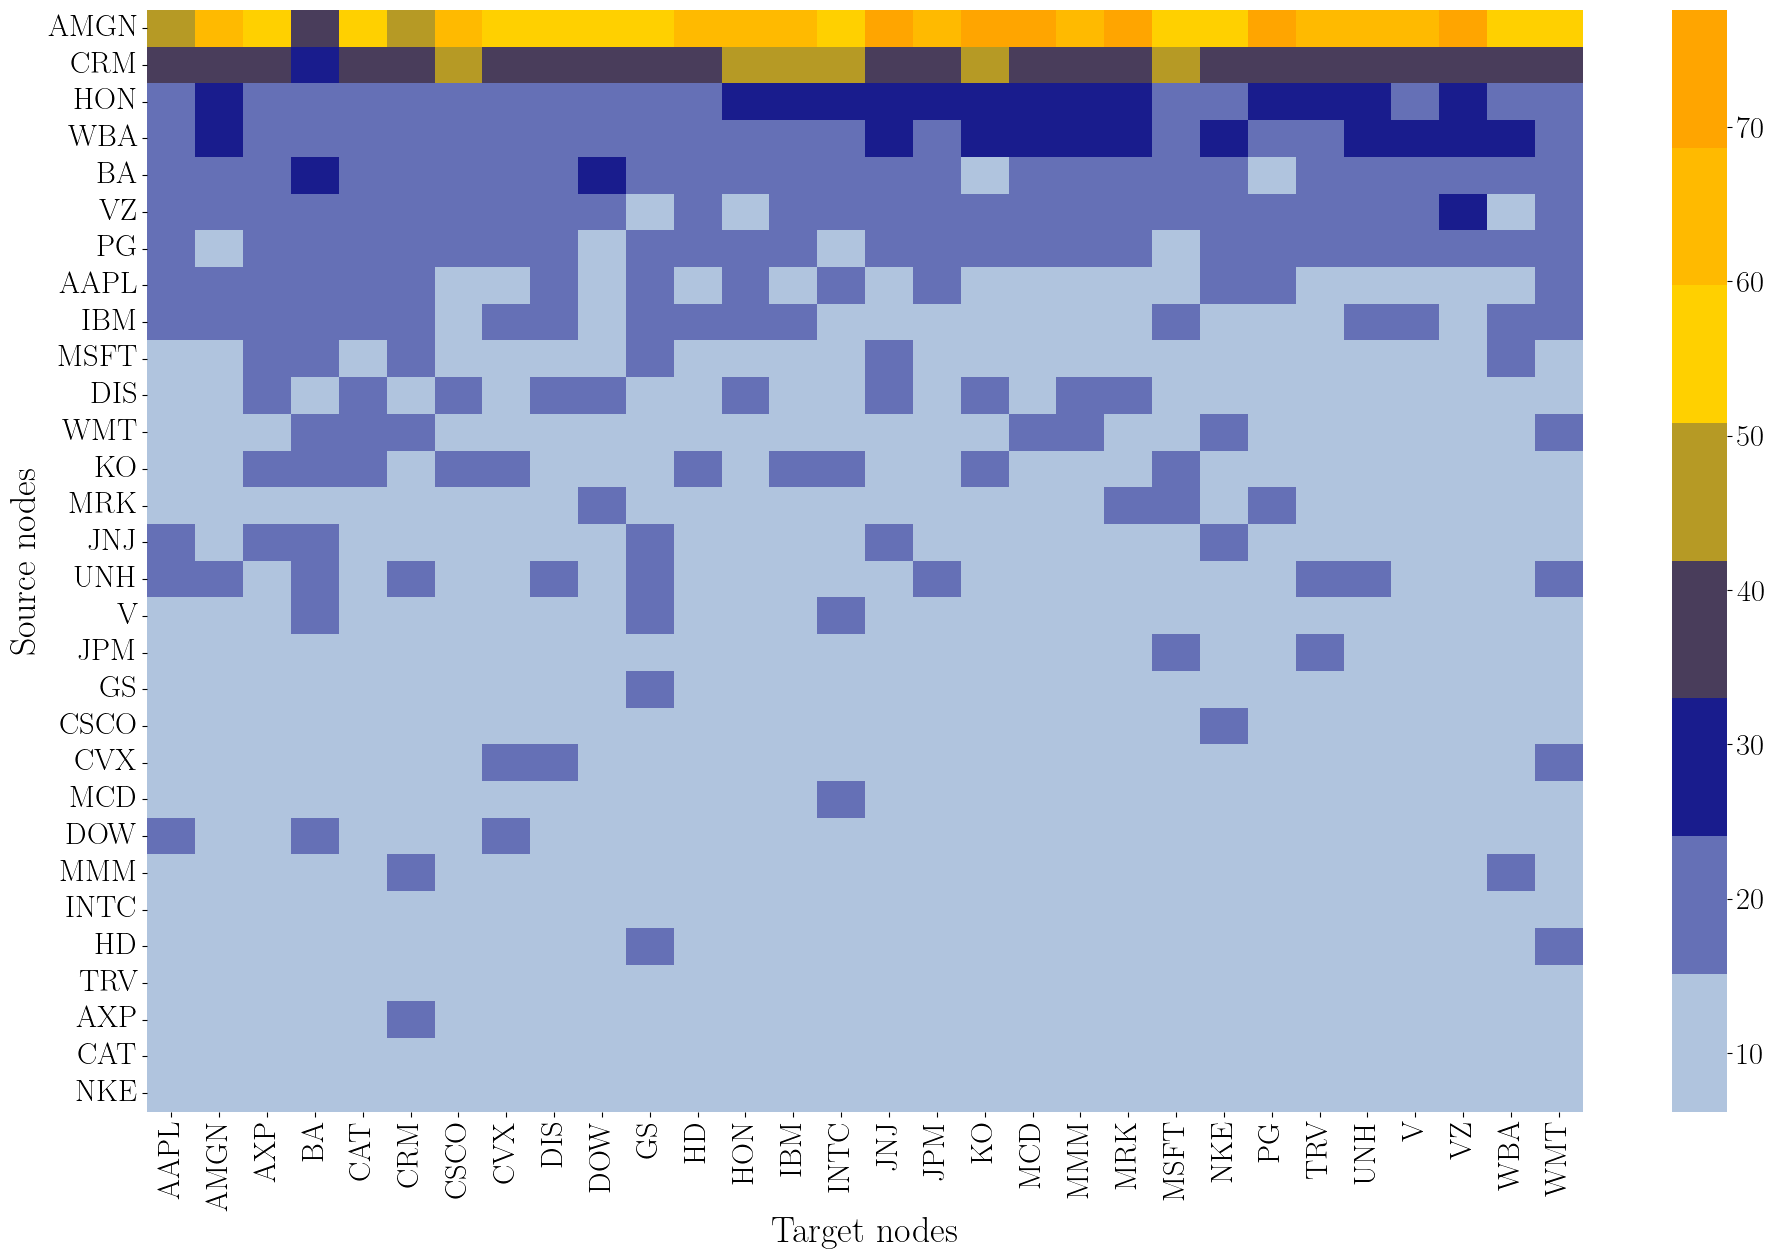

In [11]:
constituents = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW',
                'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
                'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
cmap = LinearSegmentedColormap.from_list('custom', ['lightsteelblue', 'navy', 'gold', 'orange'], N=8)

fig,ax = plt.subplots(figsize=set_size(columnwidth*4))

sns.heatmap(df_pct, cmap=cmap,yticklabels=list(new_idx),xticklabels=constituents,linecolor='gray')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)  # Keep y-axis labels as they are

ax.set_ylabel('Source nodes', fontsize = 26)
ax.set_xlabel('Target nodes', fontsize = 26)

# fig.savefig('figs/GNNexp_val_10nodes.pdf', format='pdf', bbox_inches='tight', dpi=150)
fig.savefig('figs/GNNexp_val_5nodes_highres.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Graph Visualization

In [65]:
import networkx as nx
import matplotlib.pyplot as plt

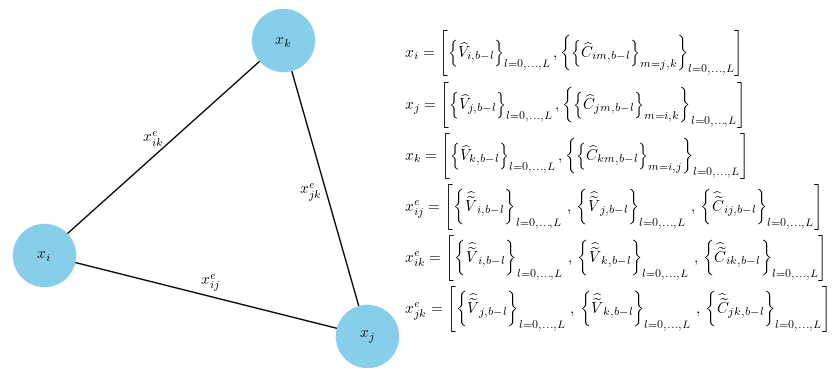

In [85]:
fsize = 17

# Ensure that amsmath is used in matplotlib's LaTeX
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"

# List of three nodes to focus on
focus_nodes = ['i', 'j', 'k']
fig = plt.figure(figsize=set_size(columnwidth))
# plt.xlim(plt.xlim()[0], plt.xlim()[1] + 1.0)

G = nx.Graph()

# Add the three nodes to the graph
for node in focus_nodes:
    G.add_node(node)

# Connect all three nodes
for i in range(len(focus_nodes)):
    for j in range(i+1, len(focus_nodes)):
        G.add_edge(focus_nodes[i], focus_nodes[j])

# Draw the graph
pos = nx.spring_layout(G, seed=34)
nx.draw(G, pos, with_labels=False, node_size=2000, node_color="skyblue")

# Add node names inside the nodes
for node, (x, y) in pos.items():
    plt.text(x, y, r"$x_{" + node + "}$", horizontalalignment='center', verticalalignment='center', fontsize=fsize, fontweight='bold')

content_x_coord = max(x for _, (x, _) in pos.items()) + 0.2

y_range = np.array([1.1,0.8,0.5])-0.2


# Function to calculate a small perpendicular offset
def perpendicular_offset(x1, y1, x2, y2, offset=2):
    dx = x2 - x1
    dy = y2 - y1
    norm = np.sqrt(dx**2 + dy**2)
    # Perpendicular direction
    dx_perp = -dy / norm
    dy_perp = dx / norm
    return x1 + dx/2 + offset*dx_perp, y1 + dy/2 + offset*dy_perp

# Add edge features using math notation
for (n1, n2) in G.edges():
    x1, y1 = pos[n1]
    x2, y2 = pos[n2]

    # Calculate offset position for the edge label
    edge_label_x, edge_label_y = perpendicular_offset(x1, y1, x2, y2, offset=0.11)

    edge_content = r"$x^{e}_{" + n1 + n2 + r"}$"
    plt.text(edge_label_x, edge_label_y, edge_content, horizontalalignment='center', verticalalignment='center', fontsize=fsize)

# Save the focused figure with a bounding box
plt.savefig('figs/zoomgraph_no_text.pdf', format="pdf", bbox_inches='tight')

# Multioutput Models

In [7]:
# Evaluate on the test set
model.eval()
criterion = torch.nn.MSELoss()

test_loss = 0
preds_val = []
actual_val = []
naive_benchmark = []
with torch.no_grad():
    for data in tqdm(iterable=test_loader, desc='Testing batches...'):
        data = data.to(device)
        # Forward pass
        y_x_hat = model(data)*scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        preds_val.append(y_x_hat)
        # Compute loss
        y_x = data.y_x*scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        actual_val.append(y_x)


        test_loss += criterion(y_x_hat,y_x)
        
# Compute average test loss
mse = test_loss / len(test_loader)
rmse = math.sqrt(mse)


preds_val = torch.concat(preds_val)
actual_val = torch.concat(actual_val)

reshaped_preds_val = preds_val.view(-1, 30, 14)
reshaped_actual_val = actual_val.view(-1, 30, 14)

Testing batches...: 100%|████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 19.43s/it]


## Repeat on Test Set

In [10]:
# test data
p['volvolfile'] = 'processed_data/volvols_mats_taq_standardized.h5'
p['volfile'] = 'processed_data/vols_mats_taq_standardized.h5'
p['root'] =  'processed_data/vols_mats_taq_standardized_test'

# Instantiate the dataset
if p['fully_connected']:
    if p['output_node_channels'] == 1:
        test_dataset = CovarianceLaggedDataset(hdf5_file1=p['volfile'], hdf5_file2=p['volvolfile'],root='_'.join([p['root'],str(p['seq_length'])]), seq_length=p['seq_length'])
    else:
        test_dataset = CovarianceLaggedMultiOutputDataset(hdf5_file1=p['volfile'], hdf5_file2=p['volvolfile'],root='_'.join([p['root'],str(p['seq_length']),'moutput']), seq_length=p['seq_length'], future_steps=p['output_node_channels'])
else:
    if p['threshold']:
        root = '_'.join([p['root'],'sparse','t_{}'.format(p['threshold']),str(p['seq_length'])])
    else:
        root = '_'.join([p['root'],'sparse',str(p['seq_length'])])
    test_dataset = CovarianceSparseDataset(hdf5_file=p['datafile'],root=root, seq_length=p['seq_length'], threshold=p['threshold'])
    p['num_edge_features'] = 1

len_test_dataset = len(test_dataset)
    
test_loader = DataLoader(test_dataset, batch_size=p['batch_size'], shuffle=False)

# Evaluate on the test set
model.eval()
criterion = torch.nn.MSELoss()

test_loss = 0
preds_test = []
actual_test = []
with torch.no_grad():
    for data in tqdm(iterable=test_loader, desc='Testing batches...'):
        data = data.to(device)
        # Forward pass
        y_x_hat = model(data)*scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        preds_test.append(y_x_hat)
        # Compute loss
        y_x = data.y_x *scalers.loc['Variance','Std'] + scalers.loc['Variance','Mean']
        actual_test.append(y_x)


        test_loss += criterion(y_x_hat,y_x)
        
# Compute average test loss
mse = test_loss / len(test_loader)
rmse = math.sqrt(mse)


preds_test = torch.concat(preds_test)
actual_test = torch.concat(actual_test)

reshaped_preds_test = preds_test.view(-1,30,14)
reshaped_actual_test = actual_test.view(-1,30,14)

Testing batches...: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:37<00:00,  2.22s/it]


RuntimeError: shape '[-1, 30, 14]' is invalid for input of size 64710

## Real vs Actual Plots

In [9]:
df_to_concat = []
for filename in tqdm(glob(os.path.join(os.getcwd(),'processed_data','vol','*.csv')),desc='Joining RVols...'):
    df = pd.read_csv(filename, header=None)

    # df = df.stack().reset_index(drop=True)
    df = pd.concat([df[col] for col in df], ignore_index=True)
    symbol = filename.split('\\')[-1].split('.')[0]
    df.name = symbol
    df_to_concat.append(df)


vol_df = pd.concat(df_to_concat,axis=1)
# vol_df = vol_df.iloc[:len(dataset),:] #* p['scale_up']

companies = list(vol_df.columns)

from pandas.tseries.holiday import USFederalHolidayCalendar
ts = pd.read_csv(os.path.join(os.getcwd(),'processed_data','timestamps.csv'), index_col=0)

ts['0'] = pd.to_datetime(ts['0'])

# Set the date column as the index
ts.set_index('0', inplace=True)

# Resample the data to 30-minute intervals
ts_resampled = ts.resample('30T').mean()

# Filter the data to only include times between 9:30 and 16:00
ts_filtered = ts_resampled.between_time('09:30', '16:00')


# Get US federal holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=ts_filtered.index.min(), end=ts_filtered.index.max())

# Remove rows with holiday dates
ts_filtered_noholidays = ts_filtered[~ts_filtered.index.floor('D').isin(holidays) & ~ts_filtered.index.dayofweek.isin([5, 6])]


Joining RVols...: 100%|███████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.66it/s]
C:\Users\ab978\AppData\Local\Temp\ipykernel_18692\2117393399.py:26: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts_resampled = ts.resample('30T').mean()


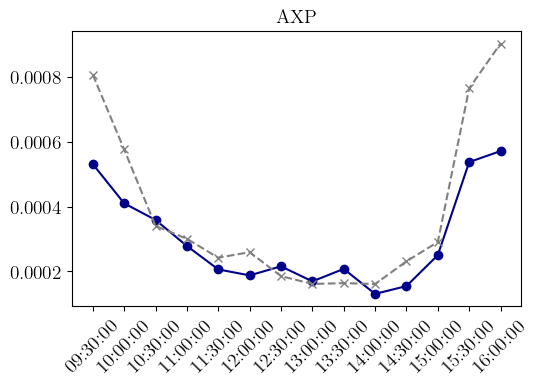

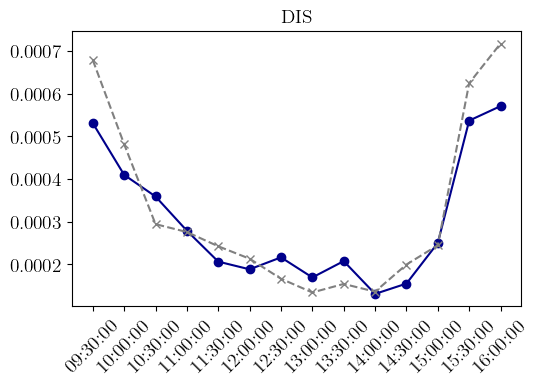

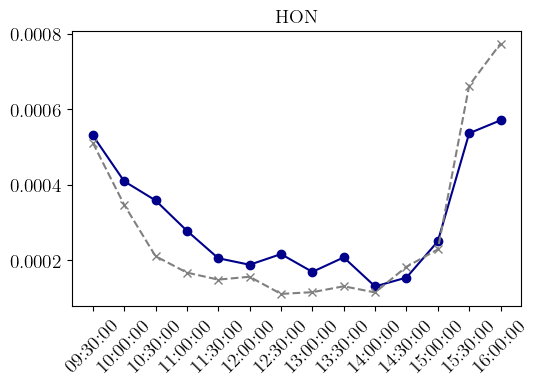

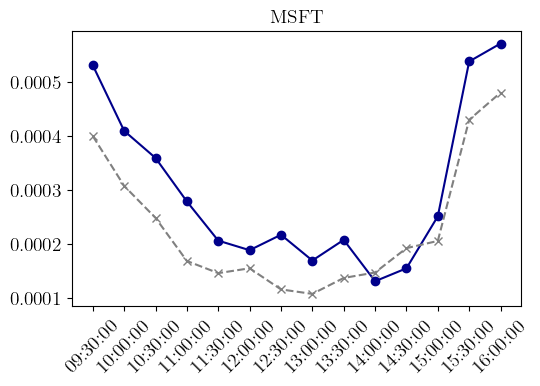

In [10]:
# idx to use are 2, 8, 12, 21
idxs = [2, 8, 11, 19]
for COMPANY_IDX in idxs:
    m = 40 #5
    TIMESTEP = 11 + 14 * m

    datetime_objs  = ts_filtered_noholidays[train_size + TIMESTEP :train_size + TIMESTEP + 14].index
    
    # Extract the date and time components
    dates = [dt_obj.date() for dt_obj in datetime_objs]
    times = [dt_obj.time() for dt_obj in datetime_objs]
    
    
    # Extract predictions and actual values for the specified timestep and company
    predictions = reshaped_preds_val[TIMESTEP+1:TIMESTEP+14+1, COMPANY_IDX].numpy()
    actuals = reshaped_actual_val[TIMESTEP+1:TIMESTEP+14+1, COMPANY_IDX].numpy()
    
    # Create a range for the x-axis (number of steps)
    steps = np.arange(len(predictions))
    
    # Plotting
    fig = plt.figure(figsize=set_size(columnwidth))
    plt.plot(steps, predictions, label='$\widehat{V}(t)$', marker='o', color='darkblue')
    plt.plot(steps, actuals, label='$V(t)$', marker='x', ls='--', color='gray')
    
    # Adding titles and labels
    plt.title(f'{companies[COMPANY_IDX]}')
    plt.xticks(steps, times, rotation=45);  # Adjust rotation if necessary
    # fig.savefig('figs/multipreds_{}_on_2022-09-19.pdf'.format(companies[COMPANY_IDX],dates[0]), format='pdf', bbox_inches='tight', dpi=150)

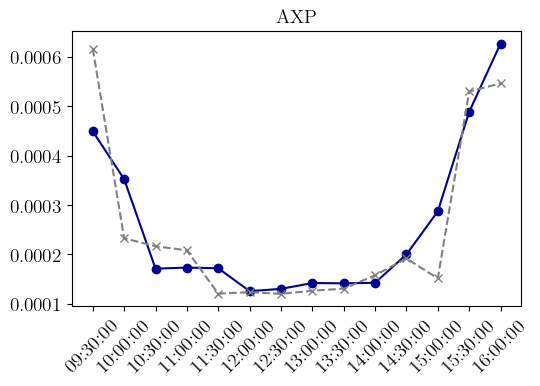

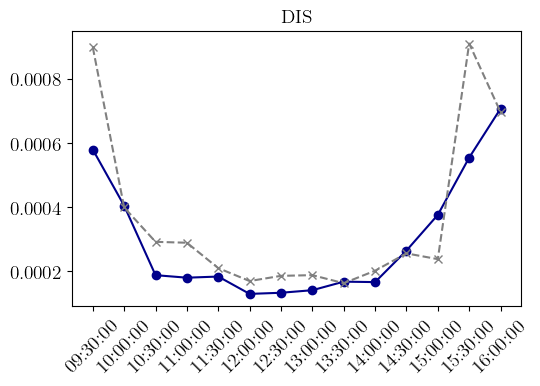

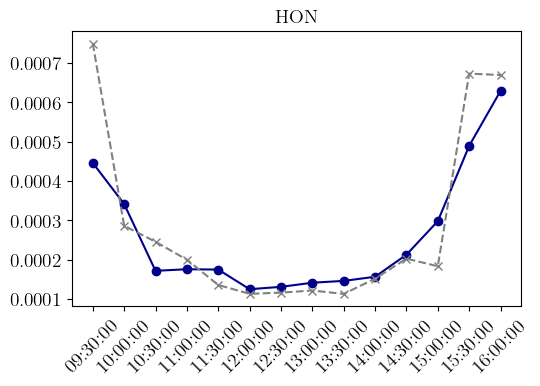

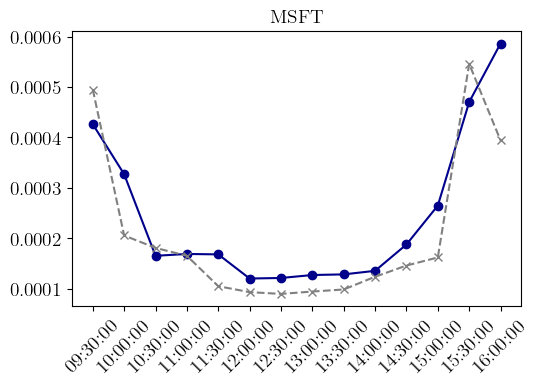

In [11]:
# idx to use are 2, 8, 12, 21
idxs = [2, 8, 11, 19]
for COMPANY_IDX in idxs:
    m = 50 
    TIMESTEP = 1 + 14 * m
    datetime_objs  = ts_filtered_noholidays[len(dataset) + TIMESTEP :len(dataset) + TIMESTEP + 14].index
    
    # Extract the date and time components
    dates = [dt_obj.date() for dt_obj in datetime_objs]
    times = [dt_obj.time() for dt_obj in datetime_objs]
    
    
    # Extract predictions and actual values for the specified timestep and company
    predictions = reshaped_preds_test[TIMESTEP+1:TIMESTEP+14+1, COMPANY_IDX].numpy()
    actuals = reshaped_actual_test[TIMESTEP+1:TIMESTEP+14+1, COMPANY_IDX].numpy()
    
    # Create a range for the x-axis (number of steps)
    steps = np.arange(len(predictions))
    
    # Plotting
    fig = plt.figure(figsize=set_size(columnwidth))
    plt.plot(steps, predictions, label='$\widehat{V}(t)$', marker='o', color='darkblue')
    plt.plot(steps, actuals, label='$V(t)$', marker='x', ls='--', color='gray')
    
    # Adding titles and labels
    plt.title(f'{companies[COMPANY_IDX]}')
    # Setting x-ticks and x-tick labels
    plt.xticks(steps, times, rotation=45);  # Adjust rotation if necessary
    
    # fig.savefig('figs/multipreds_{}_on_2023-02-01_test3.pdf'.format(companies[COMPANY_IDX],dates[0]), format='pdf', bbox_inches='tight', dpi=150)

# Predictions - MCS and DM Test

In [ ]:
# change from single to multi when running this for multistep ahead predictions
file_directory = os.path.join(os.getcwd(),'predictions')

single_actual_val = torch.load(os.path.join(file_directory, 'single_actual_val.pt')).numpy()
print(single_actual_val.shape,single_actual_val.mean())
single_actual_test = torch.load(os.path.join(file_directory, 'single_actual_test.pt')).numpy()
print(single_actual_test.shape,single_actual_test.mean())

single_arf_val = torch.load(os.path.join(file_directory, 'single_arf_val_new.pt'))
print(single_arf_val.shape,single_arf_val.mean())
single_arf_test = torch.load(os.path.join(file_directory, 'single_arf_test_new.pt'))
print(single_arf_test.shape,single_arf_test.mean())

single_HAR_val = torch.load(os.path.join(file_directory, 'single_HAR_val_new.pt'))
print(single_HAR_val.shape,single_HAR_val.mean())
single_HAR_test = torch.load(os.path.join(file_directory, 'single_HAR_test_new.pt'))
print(single_HAR_test.shape,single_HAR_test.mean())

single_XGB_val = torch.load(os.path.join(file_directory, 'single_xgb_val_new.pt'))
print(single_XGB_val.shape,single_XGB_val.mean())
single_XGB_test = torch.load(os.path.join(file_directory, 'single_xgb_test_new.pt'))
print(single_XGB_test.shape,single_XGB_test.mean())

single_LSTM_val = torch.load(os.path.join(file_directory, 'single_lstm_val_new.pt'))
print(single_LSTM_val.shape,single_LSTM_val.mean())
single_LSTM_test = torch.load(os.path.join(file_directory, 'single_lstm_test_new.pt'))
print(single_LSTM_test.shape,single_LSTM_test.mean())

single_GATnoedge_val = torch.load(os.path.join(file_directory, 'single_GATnoedge_val_new.pt'))
print(single_GATnoedge_val.shape,single_GATnoedge_val.mean())
single_GATnoedge_test = torch.load(os.path.join(file_directory, 'single_GATnoedge_test_new.pt'))
print(single_GATnoedge_test.shape,single_GATnoedge_test.mean())

single_GAT_val = torch.load(os.path.join(file_directory, 'single_GAT_val_new.pt'))
print(single_GAT_val.shape,single_GAT_val.mean())
single_GAT_test = torch.load(os.path.join(file_directory, 'single_GAT_test_new.pt'))
print(single_GAT_test.shape,single_GAT_test.mean())

In [ ]:
print('Validation')
print('ARFIMA',mean_squared_error(single_actual_val,single_arf_val))
print('HAR',mean_squared_error(single_actual_val,single_HAR_val))
print('XGB',mean_squared_error(single_actual_val,single_XGB_val))
print('LSTM',mean_squared_error(single_actual_val,single_LSTM_val))
print('GATnoedge',mean_squared_error(single_actual_val,single_GATnoedge_val))
print('GAT',mean_squared_error(single_actual_val,single_GAT_val))

print()

print('Test')
print('ARFIMA',mean_squared_error(single_actual_test,single_arf_test))
print('HAR',mean_squared_error(single_actual_test,single_HAR_test))
print('XGB',mean_squared_error(single_actual_test,single_XGB_test))
print('LSTM',mean_squared_error(single_actual_test,single_LSTM_test))
print('GATnoedge',mean_squared_error(single_actual_test,single_GATnoedge_test))
print('GAT',mean_squared_error(single_actual_test,single_GAT_test))

In [3]:
def meanqlike(y,yhat):
    return np.mean(y/yhat - np.log(y/yhat) - 1)

In [5]:
print('MSE')
print('Validation')
print('ARFIMA',mean_squared_error(single_actual_val,single_arf_val))
print('HAR',mean_squared_error(single_actual_val,single_HAR_val))
print('XGB',mean_squared_error(single_actual_val,single_XGB_val))
print('LSTM',mean_squared_error(single_actual_val,single_LSTM_val))
print('GATnoedge',mean_squared_error(single_actual_val,single_GATnoedge_val))
print('GAT',mean_squared_error(single_actual_val,single_GAT_val))

print()

print('Test')
print('ARFIMA',mean_squared_error(single_actual_test,single_arf_test))
print('HAR',mean_squared_error(single_actual_test,single_HAR_test))
print('XGB',mean_squared_error(single_actual_test,single_XGB_test))
print('LSTM',mean_squared_error(single_actual_test,single_LSTM_test))
print('GATnoedge',mean_squared_error(single_actual_test,single_GATnoedge_test))
print('GAT',mean_squared_error(single_actual_test,single_GAT_test))

print()
print('QLIKE')
print('Validation')
print('ARFIMA',meanqlike(single_actual_val,single_arf_val))
print('HAR',meanqlike(single_actual_val,single_HAR_val))
print('XGB',meanqlike(single_actual_val,single_XGB_val))
print('LSTM',meanqlike(single_actual_val,single_LSTM_val))
print('GATnoedge',meanqlike(single_actual_val,single_GATnoedge_val))
print('GAT',meanqlike(single_actual_val,single_GAT_val))

print()

print('Test')
print('ARFIMA',meanqlike(single_actual_test,single_arf_test))
print('HAR',meanqlike(single_actual_test,single_HAR_test))
print('XGB',meanqlike(single_actual_test,single_XGB_test))
print('LSTM',meanqlike(single_actual_test,single_LSTM_test))
print('GATnoedge',meanqlike(single_actual_test,single_GATnoedge_test))
print('GAT',meanqlike(single_actual_test,single_GAT_test))

MSE
Validation
ARFIMA 3.707246e-08
HAR 5.2783808e-08
XGB 3.1479992e-08
LSTM 1.0025253e-07
GATnoedge 3.2608877e-08
GAT 2.997798e-08

Test
ARFIMA 5.486996e-08
HAR 5.0898052e-08
XGB 6.232e-08
LSTM 5.1980013e-08
GATnoedge 5.1150018e-08
GAT 4.884999e-08

QLIKE
Validation
ARFIMA 1.4295133e-08
HAR 2.5457933e-08
XGB 1.4825111e-08
LSTM 5.1971067e-08
GATnoedge 1.45826995e-08
GAT 1.3313605e-08

Test
ARFIMA 4.7427385e-08
HAR 2.417823e-08
XGB 4.995321e-08
LSTM 2.8009016e-08
GATnoedge 3.314375e-08
GAT 3.0559157e-08


## MCS

https://arch.readthedocs.io/en/stable/multiple-comparison/multiple-comparison_examples.html

In [27]:
from arch.bootstrap import MCS
def qlike(y,yhat):
    return y/yhat - np.log(y/yhat) - 1

In [28]:
# MSE on VAl
models = ['ARFIMA', 'HAR', 'XGB', 'LSTM', 'SPOtV2NetNoedge', 'SpotV2Net']
vals = [single_arf_val, single_HAR_val, single_XGB_val, single_LSTM_val, 
        single_GATnoedge_val, single_GAT_val]


losses = pd.DataFrame(columns=models,
                      index=range(len(single_actual_val)),
                      data=np.array([(single_actual_val-preds)**2 for preds in vals]).transpose())

mcs = MCS(losses, size=0.05)
mcs.compute()
print("MCS P-values")
print(mcs.pvalues)

MCS P-values
                 Pvalue
Model name             
LSTM              0.000
HAR               0.000
ARFIMA            0.008
SPOtV2NetNoedge   0.011
XGB               0.385
SpotV2Net         1.000


In [29]:
# QLIKE on VAl
models = ['ARFIMA', 'HAR', 'XGB', 'LSTM', 'SPOtV2NetNoedge', 'SpotV2Net']
vals = [single_arf_val, single_HAR_val, single_XGB_val, single_LSTM_val, 
        single_GATnoedge_val, single_GAT_val]


losses = pd.DataFrame(columns=models,
                      index=range(len(single_actual_val)),
                      data=np.array([qlike(single_actual_val,preds) for preds in vals]).transpose())

mcs = MCS(losses, size=0.05)
mcs.compute()
print("MCS P-values")
print(mcs.pvalues)

MCS P-values
                 Pvalue
Model name             
HAR               0.000
LSTM              0.000
XGB               0.000
ARFIMA            0.003
SPOtV2NetNoedge   0.201
SpotV2Net         1.000


In [30]:
# MSE on TEST
models = ['ARFIMA', 'HAR', 'XGB', 'LSTM', 'SPOtV2NetNoedge', 'SpotV2Net']
tests = [single_arf_test, single_HAR_test, single_XGB_test, single_LSTM_test, 
         single_GATnoedge_test, single_GAT_test]


losses = pd.DataFrame(columns=models,
                      index=range(len(single_actual_test)),
                      data=np.array([(single_actual_test-preds)**2 for preds in tests]).transpose())

mcs = MCS(losses, size=0.05)
mcs.compute()
print("MCS P-values")
print(mcs.pvalues)

MCS P-values
                 Pvalue
Model name             
XGB               0.000
ARFIMA            0.001
SPOtV2NetNoedge   0.003
LSTM              0.064
HAR               0.244
SpotV2Net         1.000


In [31]:
# QLIKE on TEST
models = ['ARFIMA', 'HAR', 'XGB', 'LSTM', 'SPOtV2NetNoedge', 'SpotV2Net']
tests = [single_arf_test, single_HAR_test, single_XGB_test, single_LSTM_test, 
         single_GATnoedge_test, single_GAT_test]


losses = pd.DataFrame(columns=models,
                      index=range(len(single_actual_test)),
                      data=np.array([qlike(single_actual_test,preds) for preds in tests]).transpose())

mcs = MCS(losses, size=0.05)
mcs.compute()
print("MCS P-values")
print(mcs.pvalues)

MCS P-values
                 Pvalue
Model name             
XGB                 0.0
ARFIMA              0.0
SPOtV2NetNoedge     0.0
SpotV2Net           0.0
LSTM                0.0
HAR                 1.0


## DM adaptation from EPFToolbox to include QLIKE

https://github.com/jeslago/epftoolbox/blob/master/epftoolbox/evaluation/_dm.py

In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import combinations

def meanqlike(y,yhat):
    return np.mean(y/yhat - np.log(y/yhat) - 1)

def DM(p_real, p_pred_1, p_pred_2, norm=1, version='univariate'):
    """Function that performs the one-sided DM test in the contex of electricity price forecasting
    
    The test compares whether there is a difference in predictive accuracy between two forecast 
    ``p_pred_1`` and ``p_pred_2``. Particularly, the one-sided DM test evaluates the null hypothesis H0 
    of the forecasting errors of  ``p_pred_2`` being larger (worse) than the forecasting
    errors ``p_pred_1`` vs the alternative hypothesis H1 of the errors of ``p_pred_2`` being smaller (better).
    Hence, rejecting H0 means that the forecast ``p_pred_2`` is significantly more accurate
    that forecast ``p_pred_1``. (Note that this is an informal definition. For a formal one we refer to 
    `here <https://epftoolbox.readthedocs.io/en/latest/modules/cite.html>`_)

    Two versions of the test are possible:

        1. A univariate version with as many independent tests performed as prices per day, i.e. 24
        tests in most day-ahead electricity markets.

        2. A multivariate with the test performed jointly for all hours using the multivariate 
        loss differential series (see this 
        `article <https://epftoolbox.readthedocs.io/en/latest/modules/cite.html>`_ for details.

    
    Parameters
    ----------
    p_real : numpy.ndarray
        Array of shape :math:`(n_\\mathrm{days}, n_\\mathrm{prices/day})` representing the real market
        prices
    p_pred_1 : TYPE
        Array of shape :math:`(n_\\mathrm{days}, n_\\mathrm{prices/day})` representing the first forecast
    p_pred_2 : TYPE
        Array of shape :math:`(n_\\mathrm{days}, n_\\mathrm{prices/day})` representing the second forecast
    norm : int, optional
        Norm used to compute the loss differential series. At the moment, this value must either
        be 1 (for the norm-1) or 2 (for the norm-2).
    version : str, optional
        Version of the test as defined in 
        `here <https://epftoolbox.readthedocs.io/en/latest/modules/cite.html>`_. It can have two values:
        ``'univariate`` or ``'multivariate``      
    Returns
    -------
    float, numpy.ndarray
        The p-value after performing the test. It is a float in the case of the multivariate test
        and a numpy array with a p-value per hour for the univariate test

    Example
    -------
    >>> from epftoolbox.evaluation import DM
    >>> from epftoolbox.data import read_data
    >>> import pandas as pd
    >>> 
    >>> # Generating forecasts of multiple models
    >>> 
    >>> # Download available forecast of the NP market available in the library repository
    >>> # These forecasts accompany the original paper
    >>> forecasts = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/' + 
    ...                       'forecasts/Forecasts_NP_DNN_LEAR_ensembles.csv', index_col=0)
    >>> 
    >>> # Deleting the real price field as it the actual real price and not a forecast
    >>> del forecasts['Real price']
    >>> 
    >>> # Transforming indices to datetime format
    >>> forecasts.index = pd.to_datetime(forecasts.index)
    >>> 
    >>> # Extracting the real prices from the market
    >>> _, df_test = read_data(path='.', dataset='NP', begin_test_date=forecasts.index[0], 
    ...                        end_test_date=forecasts.index[-1])
    Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00
    >>> 
    >>> real_price = df_test.loc[:, ['Price']]
    >>> 
    >>> # Testing the univariate DM version on an ensemble of DNN models versus an ensemble
    >>> # of LEAR models
    >>> DM(p_real=real_price.values.reshape(-1, 24), 
    ...     p_pred_1=forecasts.loc[:, 'LEAR Ensemble'].values.reshape(-1, 24), 
    ...     p_pred_2=forecasts.loc[:, 'DNN Ensemble'].values.reshape(-1, 24), 
    ...     norm=1, version='univariate')
    array([9.99999944e-01, 9.97562415e-01, 8.10333949e-01, 8.85201928e-01,
           9.33505978e-01, 8.78116764e-01, 1.70135981e-02, 2.37961920e-04,
           5.52337353e-04, 6.07843340e-05, 1.51249750e-03, 1.70415008e-03,
           4.22319907e-03, 2.32808010e-03, 3.55958698e-03, 4.80663621e-03,
           1.64841032e-04, 4.55829140e-02, 5.86609688e-02, 1.98878375e-03,
           1.04045731e-01, 8.71203187e-02, 2.64266732e-01, 4.06676195e-02])
    >>> 
    >>> # Testing the multivariate DM version
    >>> DM(p_real=real_price.values.reshape(-1, 24), 
    ...     p_pred_1=forecasts.loc[:, 'LEAR Ensemble'].values.reshape(-1, 24), 
    ...     p_pred_2=forecasts.loc[:, 'DNN Ensemble'].values.reshape(-1, 24), 
    ...     norm=1, version='multivariate')
    0.003005725748326471
    """

    # Checking that all time series have the same shape
    if p_real.shape != p_pred_1.shape or p_real.shape != p_pred_2.shape:
        raise ValueError('The three time series must have the same shape')

    # Ensuring that time series have shape (n_days, n_prices_day)
    if len(p_real.shape) == 1 or (len(p_real.shape) == 2 and p_real.shape[1] == 1):
        raise ValueError('The time series must have shape (n_days, n_prices_day')

    # Computing the errors of each forecast
    errors_pred_1 = p_real - p_pred_1
    errors_pred_2 = p_real - p_pred_2


    # Computing the test statistic
    if version == 'univariate':

        # Computing the loss differential series for the univariate test
        if norm == 1:
            d = np.abs(errors_pred_1) - np.abs(errors_pred_2)
        if norm == 2:
            d = errors_pred_1**2 - errors_pred_2**2

        # Computing the loss differential size
        N = d.shape[0]

        # Computing the test statistic
        mean_d = np.mean(d, axis=0)
        var_d = np.var(d, ddof=0, axis=0)
        DM_stat = mean_d / np.sqrt((1 / N) * var_d)

    elif version == 'multivariate':

        # Computing the loss differential series for the multivariate test
        if norm == 1:
            d = np.mean(np.abs(errors_pred_1), axis=1) - np.mean(np.abs(errors_pred_2), axis=1)
        if norm == 2:
            d = np.mean(errors_pred_1**2, axis=1) - np.mean(errors_pred_2**2, axis=1)
        if norm == 3: #qlike
            d = (np.mean(p_real/p_pred_1 - np.log(p_real/p_pred_1) - 1, axis=1) - 
                 np.mean(p_real/p_pred_2 - np.log(p_real/p_pred_2) - 1, axis=1))
            

        # Computing the loss differential size
        N = d.size

        # Computing the test statistic
        mean_d = np.mean(d)
        var_d = np.var(d, ddof=0)
        # print(d.shape,mean_d,var_d)
        DM_stat = mean_d / np.sqrt((1 / N) * var_d)
        
    p_value = 1 - stats.norm.cdf(DM_stat)

    return DM_stat,p_value

In [4]:
# change from single to multi to perform the same for multi-step models
models = ['ARFIMA', 'HAR', 'XGB', 'LSTM', 'SPOtV2NetNoedge', 'SpotV2Net']
vals = [single_arf_val, single_HAR_val, single_XGB_val, single_LSTM_val, single_GATnoedge_val, single_GAT_val]
tests = [single_arf_test, single_HAR_test, single_XGB_test, single_LSTM_test, single_GATnoedge_test, single_GAT_test]

In [7]:
dmdf_mse_val = pd.DataFrame(index=models, columns=models)
y = single_actual_val
# Iterate over each combination of models and evaluate
for (i, model1), (j, model2) in combinations(enumerate(models), 2):
    S, pval = DM(y.reshape(-1,30), 
                   vals[i].reshape(-1,30),
                   vals[j].reshape(-1,30), 
                   norm=2,
                  version='multivariate')
    # Store the results in the DataFrame
    dmdf_mse_val.at[model1, model2] = (np.round(S,2), np.round(pval,2))

    S, pval = DM(y.reshape(-1,30), 
                   vals[j].reshape(-1,30),
                   vals[i].reshape(-1,30), 
                   norm=2,
                  version='multivariate')
    # Store the results in the DataFrame
    dmdf_mse_val.at[model2, model1] = (np.round(S,2), np.round(pval,2))
    # print(model2,model1)
    # print(S,pval)
print('DM on validation using MSE')
dmdf_mse_val

DM on validation using MSE


,ARFIMA,HAR,XGB,LSTM,SPOtV2NetNoedge,SpotV2Net
ARFIMA,NaN,"(-8.44, 1.0)","(2.15, 0.02)","(-13.11, 1.0)","(1.97, 0.02)","(3.07, 0.0)"
HAR,"(8.44, 0.0)",NaN,"(8.39, 0.0)","(-11.92, 1.0)","(13.01, 0.0)","(14.63, 0.0)"
XGB,"(-2.15, 0.98)","(-8.39, 1.0)",NaN,"(-12.5, 1.0)","(-0.66, 0.75)","(0.9, 0.18)"
LSTM,"(13.11, 0.0)","(11.92, 0.0)","(12.5, 0.0)",NaN,"(14.47, 0.0)","(15.05, 0.0)"
SPOtV2NetNoedge,"(-1.97, 0.98)","(-13.01, 1.0)","(0.66, 0.25)","(-14.47, 1.0)",NaN,"(4.15, 0.0)"
SpotV2Net,"(-3.07, 1.0)","(-14.63, 1.0)","(-0.9, 0.82)","(-15.05, 1.0)","(-4.15, 1.0)",NaN


In [8]:
dmdf_qlike_val = pd.DataFrame(index=models, columns=models)
y = single_actual_val
# Iterate over each combination of models and evaluate
for (i, model1), (j, model2) in combinations(enumerate(models), 2):
    S, pval = DM(y.reshape(-1,30), 
                   vals[i].reshape(-1,30),
                   vals[j].reshape(-1,30), 
                   norm=3,
                  version='multivariate')
    # Store the results in the DataFrame
    dmdf_qlike_val.at[model1, model2] = (np.round(S,2), np.round(pval,2))

    S, pval = DM(y.reshape(-1,30), 
                   vals[j].reshape(-1,30),
                   vals[i].reshape(-1,30), 
                   norm=3,
                  version='multivariate')
    # Store the results in the DataFrame
    dmdf_qlike_val.at[model2, model1] = (np.round(S,2), np.round(pval,2))
print('DM on validation using QLIKE')
dmdf_qlike_val

DM on validation using QLIKE


,ARFIMA,HAR,XGB,LSTM,SPOtV2NetNoedge,SpotV2Net
ARFIMA,NaN,"(-13.06, 1.0)","(-1.8, 0.96)","(-14.6, 1.0)","(2.19, 0.01)","(3.77, 0.0)"
HAR,"(13.06, 0.0)",NaN,"(11.11, 0.0)","(-12.35, 1.0)","(9.47, 0.0)","(15.57, 0.0)"
XGB,"(1.8, 0.04)","(-11.11, 1.0)",NaN,"(-13.21, 1.0)","(4.04, 0.0)","(7.31, 0.0)"
LSTM,"(14.6, 0.0)","(12.35, 0.0)","(13.21, 0.0)",NaN,"(14.11, 0.0)","(14.64, 0.0)"
SPOtV2NetNoedge,"(-2.19, 0.99)","(-9.47, 1.0)","(-4.04, 1.0)","(-14.11, 1.0)",NaN,"(1.16, 0.12)"
SpotV2Net,"(-3.77, 1.0)","(-15.57, 1.0)","(-7.31, 1.0)","(-14.64, 1.0)","(-1.16, 0.88)",NaN


In [9]:
dmdf_mse_test = pd.DataFrame(index=models, columns=models)
y = single_actual_test
# Iterate over each combination of models and evaluate
for (i, model1), (j, model2) in combinations(enumerate(models), 2):
    S, pval = DM(y.reshape(-1,30), 
                   tests[i].reshape(-1,30),
                   tests[j].reshape(-1,30), 
                   norm=2,
                  version='multivariate')
    # Store the results in the DataFrame
    dmdf_mse_test.at[model1, model2] = (np.round(S,2), np.round(pval,2))

    S, pval = DM(y.reshape(-1,30), 
                   tests[j].reshape(-1,30),
                   tests[i].reshape(-1,30), 
                   norm=2,
                  version='multivariate')
    # Store the results in the DataFrame
    dmdf_mse_test.at[model2, model1] = (np.round(S,2), np.round(pval,2))
print('DM on test using MSE')
dmdf_mse_test

DM on test using MSE


,ARFIMA,HAR,XGB,LSTM,SPOtV2NetNoedge,SpotV2Net
ARFIMA,NaN,"(2.9, 0.0)","(-5.11, 1.0)","(1.98, 0.02)","(2.79, 0.0)","(4.41, 0.0)"
HAR,"(-2.9, 1.0)",NaN,"(-5.69, 1.0)","(-1.11, 0.87)","(-0.2, 0.58)","(1.68, 0.05)"
XGB,"(5.11, 0.0)","(5.69, 0.0)",NaN,"(5.89, 0.0)","(8.75, 0.0)","(10.43, 0.0)"
LSTM,"(-1.98, 0.98)","(1.11, 0.13)","(-5.89, 1.0)",NaN,"(0.7, 0.24)","(2.93, 0.0)"
SPOtV2NetNoedge,"(-2.79, 1.0)","(0.2, 0.42)","(-8.75, 1.0)","(-0.7, 0.76)",NaN,"(4.17, 0.0)"
SpotV2Net,"(-4.41, 1.0)","(-1.68, 0.95)","(-10.43, 1.0)","(-2.93, 1.0)","(-4.17, 1.0)",NaN


In [11]:
dmdf_qlike_test = pd.DataFrame(index=models, columns=models)
y = single_actual_test
# Iterate over each combination of models and evaluate
for (i, model1), (j, model2) in combinations(enumerate(models), 2):
    S, pval = DM(y.reshape(-1,30), 
                   tests[i].reshape(-1,30),
                   tests[j].reshape(-1,30), 
                   norm=3,
                  version='multivariate')
    # Store the results in the DataFrame
    dmdf_qlike_test.at[model1, model2] = (np.round(S,2), np.round(pval,2))

    S, pval = DM(y.reshape(-1,30), 
                   tests[j].reshape(-1,30),
                   tests[i].reshape(-1,30), 
                   norm=3,
                  version='multivariate')
    # Store the results in the DataFrame
    dmdf_qlike_test.at[model2, model1] = (np.round(S,2), np.round(pval,2))
print('DM on test using QLIKE')
dmdf_qlike_test

DM on test using QLIKE


,ARFIMA,HAR,XGB,LSTM,SPOtV2NetNoedge,SpotV2Net
ARFIMA,NaN,"(22.46, 0.0)","(-23.21, 1.0)","(28.83, 0.0)","(18.89, 0.0)","(23.86, 0.0)"
HAR,"(-22.46, 1.0)",NaN,"(-26.21, 1.0)","(-10.41, 1.0)","(-16.65, 1.0)","(-14.8, 1.0)"
XGB,"(23.21, 0.0)","(26.21, 0.0)",NaN,"(36.62, 0.0)","(35.58, 0.0)","(40.37, 0.0)"
LSTM,"(-28.83, 1.0)","(10.41, 0.0)","(-36.62, 1.0)",NaN,"(-13.91, 1.0)","(-11.12, 1.0)"
SPOtV2NetNoedge,"(-18.89, 1.0)","(16.65, 0.0)","(-35.58, 1.0)","(13.91, 0.0)",NaN,"(7.33, 0.0)"
SpotV2Net,"(-23.86, 1.0)","(14.8, 0.0)","(-40.37, 1.0)","(11.12, 0.0)","(-7.33, 1.0)",NaN


# Figure Motivation Section

In [7]:
import pandas as pd
from tqdm import tqdm
from glob import glob
import os

In [35]:
df_to_concat = []
for filename in tqdm(glob(os.path.join(os.getcwd(),'processed_data','vol','*.csv')),desc='Joining RVols...'):
    df = pd.read_csv(filename, header=None)

    # df = df.stack().reset_index(drop=True)
    df = pd.concat([df[col] for col in df], ignore_index=True)
    symbol = filename.split('\\')[-1].split('.')[0]
    df.name = symbol
    df_to_concat.append(df)


vol_df = pd.concat(df_to_concat,axis=1)
sorted_columns = sorted(vol_df.columns)
vol_df = vol_df[sorted_columns]
vol_df

Joining RVols...: 100%|████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.13it/s]


,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
0,0.000241,0.000345,0.001034,0.001611,0.000764,0.000585,0.000491,0.000679,0.000369,0.001315,...,0.000485,0.000388,0.000362,0.000276,0.000700,0.000745,0.000432,0.000508,0.000570,0.000446
1,0.000247,0.000348,0.001151,0.002399,0.000564,0.000593,0.000512,0.000712,0.000379,0.000889,...,0.000513,0.000335,0.000354,0.000249,0.000648,0.000540,0.000365,0.000377,0.000547,0.000324
2,0.000170,0.000256,0.000543,0.002056,0.000312,0.000321,0.000260,0.000447,0.000239,0.000554,...,0.000201,0.000178,0.000209,0.000192,0.000317,0.000282,0.000171,0.000125,0.000336,0.000196
3,0.000104,0.000237,0.000350,0.001714,0.000251,0.000235,0.000129,0.000394,0.000324,0.000488,...,0.000147,0.000116,0.000177,0.000117,0.000221,0.000174,0.000101,0.000096,0.000303,0.000148
4,0.000090,0.000144,0.000338,0.000973,0.000163,0.000253,0.000105,0.000335,0.000273,0.000370,...,0.000103,0.000083,0.000143,0.000098,0.000178,0.000173,0.000085,0.000117,0.000296,0.000131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10551,0.000031,0.000120,0.000071,0.000068,0.000075,0.000237,0.000034,0.000071,0.000061,0.000067,...,0.000081,0.000053,0.000070,0.000032,0.000073,0.000094,0.000047,0.000041,0.000083,0.000043
10552,0.000040,0.000115,0.000080,0.000088,0.000078,0.000239,0.000032,0.000075,0.000054,0.000081,...,0.000060,0.000054,0.000071,0.000029,0.000065,0.000065,0.000050,0.000048,0.000124,0.000030
10553,0.000065,0.000175,0.000077,0.000104,0.000091,0.000246,0.000051,0.000097,0.000072,0.000093,...,0.000059,0.000069,0.000098,0.000037,0.000067,0.000062,0.000067,0.000041,0.000110,0.000040
10554,0.000089,0.000154,0.000119,0.000144,0.000144,0.000386,0.000077,0.000130,0.000104,0.000131,...,0.000085,0.000098,0.000136,0.000056,0.000101,0.000103,0.000106,0.000064,0.000147,0.000066


In [39]:
vol_df.iloc[1].values[:-1]

array([0.00024662, 0.00034792, 0.0011514 , 0.0023985 , 0.0005642 ,
       0.00059253, 0.00051225, 0.00071229, 0.00037921, 0.00088919,
       0.0006489 , 0.00037347, 0.00048311, 0.00029391, 0.00076468,
       0.00026928, 0.00060101, 0.0003108 , 0.00031547, 0.00037985,
       0.0005128 , 0.00033466, 0.00035448, 0.00024885, 0.00064833,
       0.00053972, 0.00036527, 0.00037675, 0.00054664])

In [34]:
vol_df[['AXP_V','CAT_V','AXP_VZ','CAT_VZ']]

,AXP_V,CAT_V,AXP_VZ,CAT_VZ
0,4.098100e-04,0.000283,4.220000e-04,3.247500e-04
1,4.127500e-05,0.000025,7.425400e-05,2.873300e-05
2,1.976900e-05,0.000010,2.163400e-05,1.336400e-05
3,1.146900e-05,0.000009,1.291300e-05,5.612300e-06
4,3.921300e-06,0.000006,1.449900e-05,3.558000e-06
...,...,...,...,...
10551,-1.478600e-06,0.000005,3.263000e-07,4.228000e-07
10552,-2.673200e-06,0.000008,-5.193100e-07,5.459700e-07
10553,-2.184000e-06,0.000010,-9.853300e-09,2.365700e-06
10554,6.413500e-08,0.000012,2.345900e-06,6.056400e-06


# Covols

In [1]:
import pandas as pd
import os
from tqdm import tqdm
from glob import glob

In [2]:
from pandas.tseries.holiday import USFederalHolidayCalendar
ts = pd.read_csv(os.path.join(os.getcwd(),'processed_data','timestamps.csv'), index_col=0)

ts['0'] = pd.to_datetime(ts['0'])

# Set the date column as the index
ts.set_index('0', inplace=True)

# Resample the data to 30-minute intervals
ts_resampled = ts.resample('30T').mean()

# Filter the data to only include times between 9:30 and 16:00
ts_filtered = ts_resampled.between_time('09:30', '16:00')


# Get US federal holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=ts_filtered.index.min(), end=ts_filtered.index.max())

# Remove rows with holiday dates
ts_filtered_noholidays = ts_filtered[~ts_filtered.index.floor('D').isin(holidays) & ~ts_filtered.index.dayofweek.isin([5, 6])]

C:\Users\ab978\AppData\Local\Temp\ipykernel_86844\2641313250.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts_resampled = ts.resample('30T').mean()


In [3]:
df_to_concat = []
for filename in tqdm(glob(os.path.join(os.getcwd(),'processed_data','small_subset_vol','*.csv')),desc='Joining RVols...'):
    df = pd.read_csv(filename, header=None)
    df = pd.concat([df[col] for col in df], ignore_index=True)
    symbol = filename.split('\\')[-1].split('.')[0]
    df.name = symbol
    df_to_concat.append(df)

vol_df = pd.concat(df_to_concat,axis=1)

Joining RVols...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s]


In [14]:
# do the same to save covolvol
vol_df.loc[:10318-1].set_index(ts_filtered_noholidays.iloc[:10318].index).loc['2023-03'].to_csv('estimated_covol_Mar23.csv')

In [40]:
vol = pd.read_csv('estimated_covol_Mar23.csv')
vol['date'] = pd.to_datetime(vol['0']).dt.date
vol['date'] = vol['date'].astype(str)
vol.set_index('date',inplace=True)
covol = pd.read_csv('estimated_covolvol_Mar23.csv')
covol['date'] = pd.to_datetime(covol['0']).dt.date
covol['date'] = covol['date'].astype(str)
covol.set_index('date',inplace=True)

In [6]:
from matplotlib.ticker import MaxNLocator,ScalarFormatter

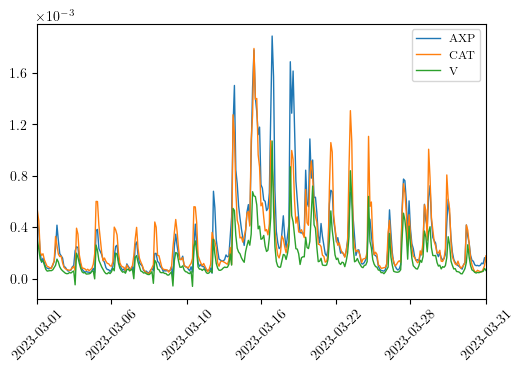

In [30]:
num_xticks = 7
num_yticks = 7

fig, ax = plt.subplots(figsize=set_size(columnwidth))

# Plot the data
vol[['AXP', 'CAT', 'V']].plot(ax=ax, lw=1.0)


# Ensure tick positions are within the bounds of the DataFrame
tick_positions = [i * (len(vol) - 1) // (num_xticks - 1) for i in range(num_xticks)]
ax.set_xticks(tick_positions)
ax.set_xticklabels([vol.index[i] for i in tick_positions], rotation=45)

# Hide the x-axis label
ax.set_xlabel('')

# Set scientific notation on the y-axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
ax.yaxis.set_major_formatter(formatter)

# Increase the number of y-axis ticks
ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks))
ax.set_xlim([0, len(vol) - 1])
# Make the legend smaller in font size
ax.legend(fontsize='small')

# Save the plot as a PDF file
fig.savefig('figs/vol_march23_fixed.pdf', format='pdf', bbox_inches='tight', dpi=150)

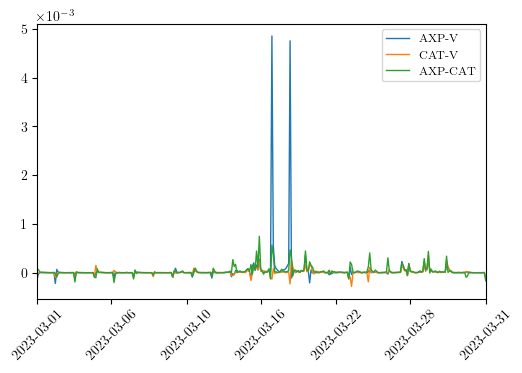

In [41]:
num_xticks = 7
num_yticks = 7

fig, ax = plt.subplots(figsize=set_size(columnwidth))

# Plot the data
covol.columns = covol.columns.str.replace('_', '-')
covol[['AXP-V', 'CAT-V', 'AXP-CAT']].plot(ax=ax, lw=1.0)

# covolplot = covol[['AXP-V', 'CAT-V', 'AXP-CAT']][maskcovol.values]
# covolplot.plot(ax=ax, lw=1.0)

# Ensure tick positions are within the bounds of the DataFrame
tick_positions = [i * (len(covol) - 1) // (num_xticks - 1) for i in range(num_xticks)]
ax.set_xticks(tick_positions)
ax.set_xticklabels([vol.index[i] for i in tick_positions], rotation=45)

# Hide the x-axis label
ax.set_xlabel('')

# Set scientific notation on the y-axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
ax.yaxis.set_major_formatter(formatter)

# Increase the number of y-axis ticks
ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks))
ax.set_xlim([0, len(covol) - 1])
# Make the legend smaller in font size
ax.legend(fontsize='small')

# Save the plot as a PDF file
fig.savefig('figs/covolvol_march23_fixed.pdf', format='pdf', bbox_inches='tight', dpi=150)